In [1]:
%matplotlib inline
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# load pretrained model
from torchvision import models

## download built-in svhn data

In [62]:
# download if necessary
if not os.path.isfile('./data/train_32x32.mat'):
    # use as digital training set
    svhn_train_set = datasets.SVHN('./data',split='train',download=True, transform=transforms.ToTensor())
if not os.path.isfile('./data/test_32x32.mat'):
    # use as digital testing set
    svhn_test_set = datasets.SVHN('./data',split='test',download=True, transform=transforms.ToTensor())
if not os.path.isdir('./data/cifar-10-batches-py'):
    # use as non-digital training set
    cifar10_train_set = datasets.CIFAR10('./data',train=True,download=True,transform=transforms.ToTensor())
    # use as non-digital testing set
    cifar10_test_set = datasets.CIFAR10('./data',train=False,download=True,transform=transforms.ToTensor())
# # print dataset information
# print("svhn train:%d, svhn test:%d, cifar train:%d, cifar test:%d"%(len(svhn_train_set),
#                                                                     len(svhn_test_set),
#                                                                     len(cifar10_train_set),
#                                                                     len(cifar10_test_set)))

###############################
# dataset class
###############################
# combine train and test together
class PartySet(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data'):
        'Initialization'
        self.transform = transform
        # load svhn
        self.svhn = datasets.SVHN(data_path,
                                  split='train' if train else 'test', 
                                  transform=transforms.ToTensor())
        self.cifar = datasets.CIFAR10(data_path,
                                      train = train,
                                      transform=transforms.ToTensor())
        # compute length
        self.l = len(self.svhn) + len(self.cifar)
        self.transform = transform
        
    def __len__(self):
        'Returns the total number of samples'
        return self.l

    def __getitem__(self, idx):
        'Generates one sample of data'
        if idx >= len(self.svhn):
            # load cifar part
            nidx = idx - len(self.svhn)
            X = self.cifar.data[nidx]
            y = 10 # new class, not digital
            #self.cifar.targets[nidx]
            X = Image.fromarray(X)
        else:
            # load svhn part
            X = self.svhn.data[idx]
            y = self.svhn.labels[idx]
            y = (y) if y < 10 else 0
            X = Image.fromarray(np.transpose(X, (1, 2, 0)))
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

In [63]:
trainset = PartySet(train=True, transform=transforms.ToTensor())

###############################
# mean, std: too slow, do once
###############################
# imgs_tensor = torch.stack([img_tensor for img_tensor, _ in trainset],dim=3)
# imgs_tensor = imgs_tensor.view(3,-1)
# mean = imgs_tensor.mean(dim=1)
# std = imgs_tensor.std(dim=1)
# print('mean:%s, std:%s'%(mean,std))
mean = [0.4597, 0.4595, 0.4623]
std = [0.2208, 0.2200, 0.2258]

# consider data augmentation if necessary
new_transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

trainset.transform = new_transform

testset = PartySet(train=False, transform=new_transform)
print(len(testset))

## data loader
batch_size = 128
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

36032


## Visulization some data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

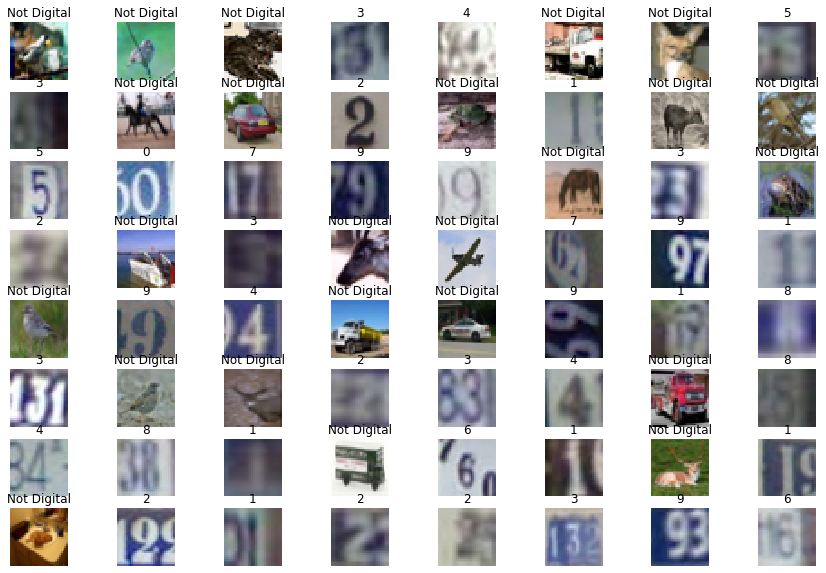

In [64]:
images, labels = next(iter(train_loader))
print(labels.shape)
plt.figure(figsize=(15,10))

label_name = ['0','1','2','3','4','5','6','7','8','9','Not Digital']

for i in range(64):
    plt.subplot(8,8,i+1)
    img = np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1)
    img = img*std+mean
    plt.imshow(img)
    plt.title(label_name[labels[i].item()])
    plt.axis('off')


## Task-1: train a CNN for digits classification
TODO:
1. use a self-defined simple network
2. use pretrained lightweight network

In [65]:
class Network(nn.Module):
    '''
    the first net is inspired by VGG-16.
    '''
    def __init__(self):
        super(Network, self).__init__()
        #...
        self.features = nn.Sequential(
            ## input is 3x32x32
            # layer-1, 32x3x28x28
            nn.Conv2d(3,32,5,stride=1,padding=0),
            nn.ReLU(),
            # layer-2, 16x32x28x28
            nn.Conv2d(32,16,1,stride=1,padding=0),
            nn.ReLU(),
            # pooling, 16x14x14
            nn.MaxPool2d(2,stride=2),
            # layer-3, 32x16x10x10
            nn.Conv2d(16,32,5,stride=1,padding=0),
            nn.ReLU(),
            # layer-4, 16x32x10x10
            nn.Conv2d(32,16,1,stride=1,padding=0),
            nn.ReLU(),
            # pooling, 16x5x5
            nn.MaxPool2d(2,stride=2)
            # 1024x1x1
            nn.Conv2d(16,1024,5,stride=1,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Conv2d(1024,1024,1,stride=1,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # 11x1x1
            nn.Conv2d(1024,11,1,stride=1,padding=0)
        )

    def forward(self, x):
        # ...
        x = self.features(x)
        out = F.softmax(x,dim=0)
        out = out.view(out.size(0), -1)
        return out

## define model and move to deive

In [66]:
usePretrained = False
if usePretrained == False:
    model = Network()
else:
    pass

for param in model.parameters():
    if param.requires_grad == True:
        print(param.shape)

# check if GPU exsit
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

torch.Size([32, 3, 5, 5])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([1024, 16, 5, 5])
torch.Size([1024])
torch.Size([1024, 1024, 1, 1])
torch.Size([1024])
torch.Size([11, 1024, 1, 1])
torch.Size([11])
The code will run on GPU. This is important so things run faster.


Network(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Conv2d(16, 1024, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Conv2d(1024, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)

## initilize optimizer

In [67]:
#Initialize the optimizer with model parameters that need to be retrained
# optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()),
#                             lr=1e-2,momentum=0.9)# fine tuning
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()),lr=1e-3)






## define training process

In [68]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    cost = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            #loss = F.nll_loss(torch.log(output), target)## what does nll_loss mean
            #Use cross-entropy as cost function 
            loss = cost(output, target)
            
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

## start training

Accuracy train: 78.5%	 test: 87.1%


Accuracy train: 90.4%	 test: 89.2%


Accuracy train: 92.2%	 test: 90.6%


Accuracy train: 93.0%	 test: 91.8%


Accuracy train: 93.6%	 test: 91.9%


Accuracy train: 93.9%	 test: 92.1%


Accuracy train: 94.4%	 test: 92.4%


Accuracy train: 94.7%	 test: 93.1%


Accuracy train: 94.9%	 test: 93.1%


Accuracy train: 95.1%	 test: 93.4%


Accuracy train: 95.3%	 test: 93.3%


Accuracy train: 95.5%	 test: 93.7%


Accuracy train: 95.6%	 test: 93.5%


Accuracy train: 95.8%	 test: 93.7%


Accuracy train: 96.0%	 test: 93.5%


Accuracy train: 96.0%	 test: 93.3%


Accuracy train: 96.1%	 test: 93.2%


Accuracy train: 96.3%	 test: 93.9%


Accuracy train: 96.3%	 test: 92.9%


Accuracy train: 96.5%	 test: 93.8%


Accuracy train: 96.5%	 test: 93.4%


Accuracy train: 96.6%	 test: 93.0%


Accuracy train: 96.7%	 test: 93.5%


Accuracy train: 96.8%	 test: 93.3%


Accuracy train: 96.7%	 test: 93.7%


[Text(0, 0.5, 'Accuracy')]

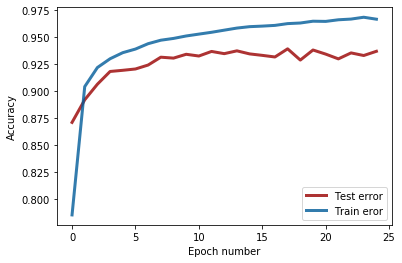

In [69]:
#optimizer = torch.optim.SGD(filter(lambda param: param.requires_grad, model.parameters()), lr=1e-2,momentum=0.9)# fine tuning

test_acc, train_acc = train(model, optimizer, 25)# training

fig,ax = plt.subplots()
ax.plot(test_acc,c='#990000',alpha=0.8,linewidth=3,label='test_acc')
ax.plot(train_acc,c='#005b99',alpha=0.8,linewidth=3,label='train_acc')
# ...
ax.legend(('Test error','Train eror'))
ax.set(xlabel='Epoch number')
ax.set(ylabel='Accuracy')


## end training, save model parameters for later usage

In [70]:

# save trained model for faster analysis
checkpoint_name = './model/party-checkpoint-0.pt'
torch.save(model.state_dict(), checkpoint_name)


## load trained  parameters and start for localization

In [71]:
checkpoint_name = './model/party-checkpoint-0.pt'

# then training
model.load_state_dict(torch.load(checkpoint_name))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [72]:
print(model)

Network(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Conv2d(16, 1024, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.5)
    (6): Conv2d(1024, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)


In [73]:
# load failure images
model.eval()
init = False
test_correct = 0
for data, target in test_loader:
    datagpu = data.to(device)
    with torch.no_grad():
        output = model(datagpu)
        predicted = output.argmax(1).cpu()
        mask = target!=predicted
        failures = data[mask]
        failure_predict_lbs = predicted[mask]
        failure_true_lbs = target[mask]
        test_correct += (target==predicted).sum().cpu().item()
        if init == False:
            init = True
            allfailures = failures
            all_failure_predict_lbs = failure_predict_lbs
            all_failure_true_lbs = failure_true_lbs
        else:
            allfailures = torch.cat((allfailures,failures),dim=0)
            all_failure_predict_lbs = torch.cat((all_failure_predict_lbs,failure_predict_lbs),0)
            all_failure_true_lbs = torch.cat((all_failure_true_lbs,failure_true_lbs),0)
print(len(testset))
print(allfailures.shape)
print(all_failure_predict_lbs)
print(all_failure_true_lbs)
test_acc = test_correct/len(testset)
print('Test Accuracy:%s'%test_acc)

36032
torch.Size([2273, 3, 32, 32])
tensor([9, 5, 6,  ..., 1, 9, 9])
tensor([ 8,  8,  8,  ..., 10, 10, 10])
Test Accuracy:0.9369171847246892


## Use your network with a **convolutional implementation of the sliding window** algorithm to detect bounding boxes around digits.

In [5]:
class PartyFull(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/SVHN'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.png')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        # fetch folder name as the class type
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [6]:
full_test_set = PartyFull(train=False, transform=[])

In [3]:
a = torch.Tensor([[1,22,3],[2,33,44]])
print(a)
print(F.softmax(a,dim=0))
print(a.shape)

tensor([[ 1., 22.,  3.],
        [ 2., 33., 44.]])
tensor([[2.6894e-01, 1.6701e-05, 1.5629e-18],
        [7.3106e-01, 9.9998e-01, 1.0000e+00]])
torch.Size([2, 3])


torch.Size([2, 3])


	+ Label: 2, Conf: 0.90000
155.0,155.0
	+ Label: 9, Conf: 0.80000
15.0,50.0


<Figure size 432x288 with 0 Axes>

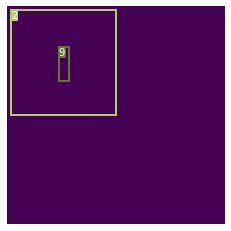

In [47]:
box = np.array([[1,2,3,4],[1,2,3,4]])
print(box[:,1])
#print(box[:,-1].unique())

[2 2]
